In [1]:
import os.path as osp

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
#from torch_geometric.nn import GCNConv
from torch_geometric.nn import GCNConv, GNNExplainer

dataset = 'Cora'
path = '..\data\Planetoid'
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset[0]




In [2]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, x, edge_index, batch = None):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


device = torch.device('cpu')
model = Net().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
x, edge_index = data.x, data.edge_index

for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    log_logits = model(x, edge_index)
    loss = F.nll_loss(log_logits[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()


In [ ]:
def hook(module, input, output):
        print(module)
        hook_outputs.append(input)
        print("printing hook output")
        print(hook_outputs[0][0])
        print(hook_outputs[0][0].shape)
        #print(type(hook_outputs))
        
with torch.no_grad():
    for i, datapoint in enumerate(test_set):
        X, edge_index, edge_weight, y = datapoint.X, datapoint.edge_index, datapoint.edge_attr, datapoint.y

Explain node 1001: 100%|████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 581.70it/s]


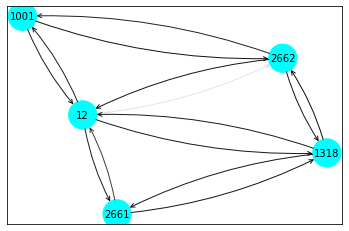

In [3]:
explainer = GNNExplainer(model, epochs=200)
node_idx = 1001
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)
plt.show()

In [4]:
node_idx = -1

Explain graph: 100%|█████████████████████████████████████████████████████████████████| 200/200 [00:05<00:00, 35.33it/s]


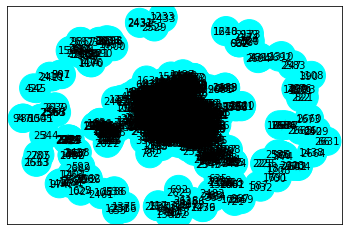

In [5]:
gnode_feat_mask, gedge_mask = explainer.explain_graph(x, edge_index)
ax, G = explainer.visualize_subgraph(node_idx, edge_index, gedge_mask, y=data.y)
plt.show()